In [41]:
%load_ext nb_black
%load_ext lab_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black
The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


<IPython.core.display.Javascript object>

This is my project for computational intelligence based on kaggle dataset of monkeys.

In [42]:
# Import packages

import os
from pathlib import Path

import cv2
import keras
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.utils import np_utils
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from tensorflow.python.keras.callbacks import ReduceLROnPlateau
from tensorflow.python.keras.layers import (
    Conv2D,
    Activation,
    MaxPooling2D,
    Dropout,
    Flatten,
    Dense,
)
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
%matplotlib inline

<IPython.core.display.Javascript object>

Set data folders

In [43]:
data_folder = "data"
training_directory = os.path.join(data_folder, "training", "training")
test_directory = os.path.join(data_folder, "validation", "validation")
labels_file = os.path.join(data_folder, "monkey_labels.txt")

<IPython.core.display.Javascript object>

Read labels

In [44]:
labels_df = pd.read_csv(labels_file)
labels_df = labels_df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
labels_df.columns = labels_df.columns.str.strip()
labels = labels_df["Common Name"]

<IPython.core.display.Javascript object>

Read images from files

In [45]:
def convert_image_to_vector(input_image, size=(32, 32)):
    resized_image = cv2.resize(input_image, size)
    return resized_image


def convert_image_to_vector_rgb(input_image, size=(32, 32)):
    resized_image = cv2.resize(input_image, size)
    img_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
    return img_rgb


def convert_image_to_vector_cubic(input_image, size=(32, 32)):
    resized_image = cv2.resize(input_image, size, interpolation=cv2.INTER_CUBIC)
    return resized_image


def convert_image_to_vector_both(input_image, size=(32, 32)):
    resized_image = cv2.resize(input_image, size, interpolation=cv2.INTER_CUBIC)
    img_rgb_cubic = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
    return img_rgb_cubic


def normalize(input_image):
    mean, std = input_image.mean(), input_image.std()
    input_image = (input_image - mean) / std
    return input_image


def process_image(file):
    image_file = cv2.imread(file)
    image_pixels = convert_image_to_vector_both(image_file, size=(32, 32))
    image_pixels = normalize(image_pixels)
    image_label = file.split(os.path.sep)[-2]
    return image_pixels, image_label

<IPython.core.display.Javascript object>

In [46]:
training_images = []
training_images_knn = []
training_labels = []

for path in Path(training_directory).rglob("*.jpg"):
     image, label = process_image(str(path))
     training_images.append(image)
     training_images_knn.append(image.flatten())
     training_labels.append(label)

test_images = []
test_images_knn = []
test_labels = []

for path in Path(test_directory).rglob("*.jpg"):
     image, label = process_image(str(path))
     test_images.append(image)
     test_labels.append(label)
     test_images_knn.append(image.flatten())


<IPython.core.display.Javascript object>

0               mantled_howler
1                 patas_monkey
2                  bald_uakari
3             japanese_macaque
4               pygmy_marmoset
5        white_headed_capuchin
6             silvery_marmoset
7       common_squirrel_monkey
8    black_headed_night_monkey
9               nilgiri_langur
Name: Common Name, dtype: object


c:\programowanko\computational-intelligence\project2\venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


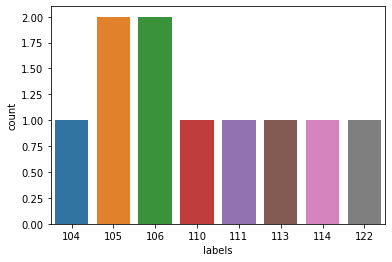

<IPython.core.display.Javascript object>

In [47]:
df = pd.DataFrame()
df["labels"]=training_labels
lab = df["labels"]
counts = lab.value_counts()
sns.countplot(counts)
print(labels)

In [48]:
test_images = np.array(test_images)
test_labels = np.array(test_labels)
test_images_knn = np.array(test_images_knn)

<IPython.core.display.Javascript object>

In [49]:
training_images = np.array(training_images)
training_labels = np.array(training_labels)
training_images_knn = np.array(training_images_knn)

num_classes = len(np.unique(training_labels))
label_encoder = LabelEncoder()
training_labels = label_encoder.fit_transform(training_labels)
test_labels = label_encoder.fit_transform(test_labels)
test_labels = np_utils.to_categorical(test_labels, num_classes)
training_labels = np_utils.to_categorical(training_labels, num_classes)

<IPython.core.display.Javascript object>

In [50]:
model = KNeighborsClassifier(n_neighbors=7)
model.fit(training_images_knn, training_labels)
acc = model.score(test_images_knn, test_labels)
print("[INFO] histogram accuracy: {:.2f}%".format(acc * 100))


[INFO] histogram accuracy: 16.91%


<IPython.core.display.Javascript object>

Prepare data

In [51]:
# Only needed when flattening the image before
# training_images = training_images.reshape(-1, 32, 32, 3)
# test_images = test_images.reshape(-1, 32, 32, 3)
# normalizing the data to help with the training

<IPython.core.display.Javascript object>

In [52]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(Conv2D(64, (3, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation("softmax"))

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# model.compile(
#     loss="categorical_crossentropy",
#     optimizer="rmsprop",
#     metrics=["accuracy"]
# )
model.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
activation_12 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
activation_13 (Activation)   (None, 13, 13, 32)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 6, 6, 64)         

<IPython.core.display.Javascript object>

In [53]:
reduce_learning_rate = ReduceLROnPlateau(monitor="loss",
                                         factor=0.1,
                                         patience=2,
                                         cooldown=1,
                                         min_lr=0.00001,
                                         verbose=1)

checkpoint_filepath = "checkpoint.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="accuracy",
    mode="max",
    save_best_only=True)

# model.fit(
#     training_images,
#     training_labels,
#     epochs=50,
#     callbacks=[reduce_learning_rate],
#     steps_per_epoch= training_images.size
# )
model.fit(training_images, training_labels, epochs=30, callbacks=[model_checkpoint_callback, ])
model.load_weights(checkpoint_filepath)

Epoch 1/30
35/35 [==============================] - 1s 18ms/step - loss: 2.2983 - accuracy: 0.1205

<IPython.core.display.Javascript object>

Test accuracy

In [54]:
test_loss, test_acc = model.evaluate(
    test_images,
    test_labels,
    verbose=2
)
print("\nTest accuracy:", test_acc)

9/9 - 0s - loss: 1.5622 - accuracy: 0.6654

Test accuracy: 0.6654411554336548


<IPython.core.display.Javascript object>

Test on one image

In [55]:
n = 200
test_image = test_images[n]
test_image = np.expand_dims(test_image, axis=0)
prediction = model.predict(test_image, batch_size=1)
print(labels[np.argmax(prediction)])
print(labels)

common_squirrel_monkey
0               mantled_howler
1                 patas_monkey
2                  bald_uakari
3             japanese_macaque
4               pygmy_marmoset
5        white_headed_capuchin
6             silvery_marmoset
7       common_squirrel_monkey
8    black_headed_night_monkey
9               nilgiri_langur
Name: Common Name, dtype: object


<IPython.core.display.Javascript object>

In [56]:
names = [
    "Alouatta Palliata - Mantled Howler",
    "Trythrocebus Patas - Patas Monkey",
    "Cacajao Calvus - Bald Uakari",
    "Macaca Fuscata - Japanese Macaque",
    "Cebuella Pygmea - Pygmy Marmoset",
    "Cebus Capucinus - White Headed Capuchin",
    "Mico Argentatus - Silvery Marmoset",
    "Saimiri Sciureus - Common Squirrel Monkey",
    "Aotus Nigriceps - Black Headed Night Monkey",
    "Trachypithecus Johnii - Nilgiri Langur"
]


IMG_SIZE = 32
size = (IMG_SIZE,IMG_SIZE)
n_CLASS = 10

datagen = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = "nearest",
    validation_split=0.2
)

train_set = datagen.flow_from_directory(
    training_directory,
    target_size = size,
    batch_size=32,
    seed = 42,
    subset="training",
    shuffle = True,
    class_mode="categorical"
)

val_set = datagen.flow_from_directory(
    training_directory,
    target_size = size,
    batch_size=32,
    seed = 42,
    subset="validation",
    shuffle = True,
    class_mode="categorical"
)


test_set = datagen.flow_from_directory(
    test_directory,
    target_size = size,
    batch_size = 32,
    seed = 42,
    class_mode = "categorical",
    shuffle = False
)

from keras.layers import GlobalAveragePooling2D
from keras.optimizers import  Adam
from keras.callbacks import  ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB3


Found 881 images belonging to 10 classes.
Found 217 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


<IPython.core.display.Javascript object>

In [57]:
image_generator_model = Sequential()
image_generator_model.add(EfficientNetB3(input_shape = (IMG_SIZE, IMG_SIZE, 3), include_top = False, weights = "imagenet"))
image_generator_model.add(GlobalAveragePooling2D())
image_generator_model.add(Flatten())
image_generator_model.add(Dense(512, activation = "relu", bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)))
image_generator_model.add(Dropout(0.7))
image_generator_model.add(Dense(n_CLASS, activation = "softmax"))

image_generator_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 1, 1, 1536)        10783535  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1536)              0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1536)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               786944    
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 10)                5130      
Total params: 11,575,609
Trainable params: 11,488,306
Non-trainable params: 87,303
_____________________________________

<IPython.core.display.Javascript object>

In [58]:
keras.utils.plot_model(image_generator_model)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


<IPython.core.display.Javascript object>

In [59]:
EPOCHS = 50
STEP_SIZE_TRAIN = train_set.n//train_set.batch_size
STEP_SIZE_VALID = val_set.n//val_set.batch_size


<IPython.core.display.Javascript object>

In [ ]:
image_generator_model.compile(
    optimizer = Adam(learning_rate = 1e-3),
    loss ="categorical_crossentropy",
    metrics = ["acc"]
)

es = EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

checkpoint_cb = ModelCheckpoint(
    "Cassava_best_model.h5",
    save_best_only=True,
    monitor = "val_loss",
    mode="min"
)

reduce_lr = ReduceLROnPlateau(
    monitor = "val_loss",
    factor = 0.3,
    patience = 3,
    min_lr = 1e-5,
    mode = "min",
    verbose = 1
)

history = image_generator_model.fit(
    train_set,
    validation_data = val_set,
    epochs= EPOCHS,
    batch_size = 32,
    steps_per_epoch = STEP_SIZE_TRAIN,
    validation_steps = STEP_SIZE_VALID,
    callbacks=[es, checkpoint_cb, reduce_lr]
)

image_generator_model.save("Cassava_model"+".h5")

Epoch 1/50


In [ ]:
print("Train_Cat-Acc: ", max(history.history["acc"]))
print("Val_Cat-Acc: ", max(history.history["val_acc"]))

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest")

train_generator = train_datagen.flow_from_directory(training_directory,
                                                    target_size=(32,32),
                                                    batch_size= 64,
                                                    seed=1,
                                                    shuffle=True,
                                                    class_mode="categorical")

# Test generator
test_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = test_datagen.flow_from_directory(test_directory,
                                                  target_size=(32,32),
                                                  batch_size=64,
                                                  seed=1,
                                                  shuffle=False,
                                                  class_mode="categorical")

train_num = train_generator.samples
validation_num = validation_generator.samples

In [ ]:
num_classes = 10

monkey_model = Sequential()
monkey_model.add(Conv2D(32,(3,3), input_shape=(32,32,3), activation="relu"))
monkey_model.add(MaxPooling2D(pool_size=(2,2)))
monkey_model.add(Conv2D(32,(3,3), activation="relu"))
monkey_model.add(MaxPooling2D(pool_size=(2,2)))
monkey_model.add(Conv2D(64,(3,3), padding="same", activation="relu"))
monkey_model.add(Conv2D(64,(3,3), activation="relu"))
monkey_model.add(MaxPooling2D(pool_size=(2,2)))
monkey_model.add(Dropout(0.25))
monkey_model.add(Flatten())
monkey_model.add(Dense(512))
monkey_model.add(Activation("relu"))
monkey_model.add(Dropout(0.5))
monkey_model.add(Dense(num_classes))
monkey_model.add(Activation("softmax"))

In [ ]:
monkey_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["acc"]
)
monkey_model.summary()

In [ ]:
filepath=str(os.getcwd()+"/model.h5f")
checkpoint = ModelCheckpoint(
    filepath,
    monitor="val_acc",
    verbose=1,
    save_best_only=True, mode="max"
)
callbacks_list = [checkpoint]
batch_size = 64

monkey_generator = monkey_model.fit(
    train_generator,
    steps_per_epoch = train_num // batch_size,
    epochs = 100,
    validation_data = train_generator,
    validation_steps = validation_num // batch_size,
    callbacks = callbacks_list,
    verbose = 1
)